In [175]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from alepython import ale_plot
from sklearn.inspection import plot_partial_dependence

In [3]:
spotify_df = pd.read_csv('/Users/briancai/Drive/NU/Q3/AVC/litness_test/2020-MSIA423-Cai-Litness-Test/data/spotify_2000_to_2020.csv', index_col = 0)

In [4]:
spotify_df.head()

,artist,track,date,chart,spotify_query,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,NLE Choppa Featuring Roddy Ricch,Walk Em Down,2020-05-01,rap-song,NLE+Choppa+Walk+Em+Down,0.867,0.744,9,-5.171,0,...,0.0713,0.645,84.005,audio_features,4cSSL3YafYjM3yjgFO1vJg,spotify:track:4cSSL3YafYjM3yjgFO1vJg,https://api.spotify.com/v1/tracks/4cSSL3YafYjM...,https://api.spotify.com/v1/audio-analysis/4cSS...,173288,4
1,DaBaby,Find My Way,2020-05-01,rap-song,DaBaby+Find+My+Way,0.836,0.624,4,-6.750,0,...,0.1380,0.700,103.000,audio_features,1gVCEnryJhkdQcuC0Kbvor,spotify:track:1gVCEnryJhkdQcuC0Kbvor,https://api.spotify.com/v1/tracks/1gVCEnryJhkd...,https://api.spotify.com/v1/audio-analysis/1gVC...,139890,4
2,Drake,Toosie Slide,2020-05-01,rap-song,Drake+Toosie+Slide,0.834,0.454,1,-9.750,0,...,0.1140,0.837,81.618,audio_features,127QTOFJsJQp5LbJbu3A1y,spotify:track:127QTOFJsJQp5LbJbu3A1y,https://api.spotify.com/v1/tracks/127QTOFJsJQp...,https://api.spotify.com/v1/audio-analysis/127Q...,247059,4
3,Roddy Ricch,The Box,2020-05-01,rap-song,Roddy+Ricch+The+Box,0.896,0.586,10,-6.687,0,...,0.7900,0.642,116.971,audio_features,0nbXyq5TXYPCO7pr3N8S4I,spotify:track:0nbXyq5TXYPCO7pr3N8S4I,https://api.spotify.com/v1/tracks/0nbXyq5TXYPC...,https://api.spotify.com/v1/audio-analysis/0nbX...,196653,4
4,DaBaby Featuring Roddy Ricch,Rockstar,2020-05-01,rap-song,DaBaby+Rockstar,0.746,0.690,11,-7.956,1,...,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4


# Data exploration / cleaning

In [5]:
spotify_df.dtypes

artist               object
track                object
date                 object
chart                object
spotify_query        object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
dtype: object

Covert BPM in the range of 80 and 160 (multiply BPMs < 80 by 2, divide BPMs > 160 by 2)

In [6]:
spotify_df.loc[spotify_df.tempo < 80, 'tempo'] = spotify_df.loc[spotify_df.tempo < 80, 'tempo'] * 2
spotify_df.loc[spotify_df.tempo > 160, 'tempo'] = spotify_df.loc[spotify_df.tempo > 160, 'tempo'] / 2

Create year column

In [7]:
spotify_df['year'] = pd.to_numeric(spotify_df['date'].str[:4])

Convert key + mode integers to key names

In [8]:
key_dict = {0:'C', 1:'Db', 2: 'D', 3:'Eb', 4:'E', 5:'F', 6:'Gb', 7:'G', 8:'Ab', 9:'A', 10:'Bb', 11:'B'}
mode_dict = {1:'major', 0:'minor'}

spotify_df['key_name'] = spotify_df['key'].map(key_dict)
spotify_df['mode_name'] = spotify_df['mode'].map(mode_dict)

spotify_df['key_full'] = spotify_df['key_name'] + spotify_df['mode_name']

## Overall differences between Rap songs and Hot 100 songs

Balanced number of Hot 100 and Rap songs 

In [9]:
spotify_df.groupby('chart')[['track']].count()

,track
chart,
hot-100,1984
rap-song,1533


Averages between Rap Song and Hot 100 charts continuous features:
- Rap songs more danceable, more speechiness (as expected), more live performance vibes, and less acoustic
- Not much difference in terms of energy, volume, valence, tempo, and duration

In [11]:
spotify_df.groupby('chart')[['danceability', 'energy', 'loudness', 
                             'speechiness', 'acousticness', 'liveness',  
                             'valence', 'tempo', 'duration_ms']].mean()

,danceability,energy,loudness,speechiness,acousticness,liveness,valence,tempo,duration_ms
chart,,,,,,,,,
hot-100,0.62526,0.693454,-5.734784,0.070695,0.162313,0.171434,0.535053,115.675254,231351.314012
rap-song,0.72835,0.687125,-5.932117,0.208740,0.123311,0.200841,0.540185,114.064139,235498.656882


Distribution of categorical variables (key and mode)

In [12]:
keycount_chart = spotify_df.groupby(['chart','key_full'])[['track']].count().reset_index(drop = False)
keycount_chart.loc[keycount_chart.chart == 'hot-100', 'perc'] = keycount_chart.loc[keycount_chart.chart == 'hot-100', 'track'] / 1984
keycount_chart.loc[keycount_chart.chart == 'rap-song', 'perc'] = keycount_chart.loc[keycount_chart.chart == 'rap-song', 'track'] / 1533

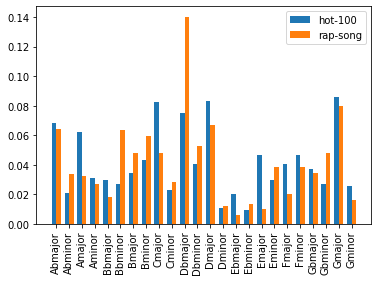

In [13]:
labels = keycount_chart.loc[keycount_chart.chart == 'hot-100', 'key_full']
hot_100_perc = keycount_chart.loc[keycount_chart.chart == 'hot-100', 'perc']
rap_song_perc = keycount_chart.loc[keycount_chart.chart == 'rap-song', 'perc']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, hot_100_perc, width, label='hot-100')
rects2 = ax.bar(x + width/2, rap_song_perc, width, label='rap-song')

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=90)
ax.legend()

Rap music much more popular in key of Db major and Bb minor. Hot 100 music more popular in A major, C major, and E major

## Differences over time

In [14]:
time_track = spotify_df.groupby(['chart', 'year'])[['danceability', 'energy', 'loudness', 
                             'speechiness', 'acousticness', 'liveness',  
                             'valence', 'tempo', 'duration_ms']].mean().reset_index()

In [15]:
def plot_year_trends(var, df):
    
    hot100 = df.loc[df.chart == 'hot-100']
    rapsong = df.loc[df.chart == 'rap-song']
    
    fig, ax = plt.subplots()
    ax.plot(hot100['year'], hot100[var], label='hot-100')
    ax.plot(rapsong['year'], rapsong[var], label='rap-song')
    ax.set_xlabel('Year')
    ax.set_ylabel(var)
    ax.legend() 

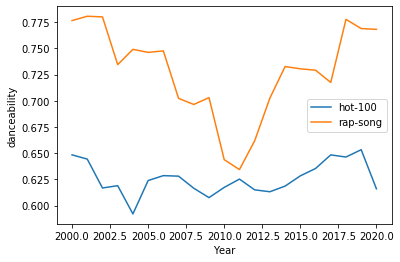

In [16]:
plot_year_trends('danceability', time_track)

In [20]:
spotify_df.columns

Index(['artist', 'track', 'date', 'chart', 'spotify_query', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'year',
       'key_name', 'mode_name', 'key_full'],
      dtype='object')

In [22]:
spotify_df[(spotify_df.year == 2011) & (spotify_df.chart == 'rap-song')].sort_values(by = 'danceability').head(20)

,artist,track,date,chart,spotify_query,danceability,energy,key,loudness,mode,...,id,uri,track_href,analysis_url,duration_ms,time_signature,year,key_name,mode_name,key_full
759,Lil Wayne Featuring Cory Gunz,6 Foot 7 Foot,2011-06-01,rap-song,Lil+Wayne+6+Foot+7+Foot,0.365,0.751,2,-5.429,1,...,0z5ZPs57J2KERwM1tBM2GF,spotify:track:0z5ZPs57J2KERwM1tBM2GF,https://api.spotify.com/v1/tracks/0z5ZPs57J2KE...,https://api.spotify.com/v1/audio-analysis/0z5Z...,248587,4,2011,D,major,Dmajor
722,"Meek Mill Featuring T.I., Birdman, Lil Wayne, ...",Ima Boss,2011-12-01,rap-song,Meek+Mill+Ima+Boss,0.370,0.870,5,-2.090,1,...,7sjwaBQ6M3aVigYfBjm1sL,spotify:track:7sjwaBQ6M3aVigYfBjm1sL,https://api.spotify.com/v1/tracks/7sjwaBQ6M3aV...,https://api.spotify.com/v1/audio-analysis/7sjw...,250240,4,2011,F,major,Fmajor
773,Lil Wayne Featuring Drake,Right Above It,2011-04-01,rap-song,Lil+Wayne+Right+Above+It,0.376,0.841,3,-4.348,0,...,1kMuU3TNQvHbqvXCWBodmP,spotify:track:1kMuU3TNQvHbqvXCWBodmP,https://api.spotify.com/v1/tracks/1kMuU3TNQvHb...,https://api.spotify.com/v1/audio-analysis/1kMu...,271947,4,2011,Eb,minor,Ebminor
780,Nicki Minaj,Right Thru Me,2011-02-01,rap-song,Nicki+Minaj+Right+Thru+Me,0.381,0.680,1,-4.724,1,...,180jaPAbXwB4nvtieXteYf,spotify:track:180jaPAbXwB4nvtieXteYf,https://api.spotify.com/v1/tracks/180jaPAbXwB4...,https://api.spotify.com/v1/audio-analysis/180j...,235773,3,2011,Db,major,Dbmajor
726,Big Sean Featuring Chris Brown,My Last,2011-11-01,rap-song,Big+Sean+My+Last,0.387,0.773,8,-5.685,1,...,70tFuqBcduJv15bEnOPRTh,spotify:track:70tFuqBcduJv15bEnOPRTh,https://api.spotify.com/v1/tracks/70tFuqBcduJv...,https://api.spotify.com/v1/audio-analysis/70tF...,254120,4,2011,Ab,major,Abmajor
766,Diddy - Dirty Money Featuring Skylar Grey,Coming Home,2011-05-01,rap-song,Diddy+-+Dirty+Money+Coming+Home,0.392,0.839,7,-1.921,1,...,6Iocm6VMu6bVNYwiDoyQFW,spotify:track:6Iocm6VMu6bVNYwiDoyQFW,https://api.spotify.com/v1/tracks/6Iocm6VMu6bV...,https://api.spotify.com/v1/audio-analysis/6Ioc...,238693,4,2011,G,major,Gmajor
717,"DJ Khaled Featuring Drake, Rick Ross & Lil Wayne",I'm On One,2011-12-01,rap-song,DJ+Khaled+I'm+On+One,0.413,0.807,11,-3.499,0,...,608a1wIsSd5KzMEqm1O7w3,spotify:track:608a1wIsSd5KzMEqm1O7w3,https://api.spotify.com/v1/tracks/608a1wIsSd5K...,https://api.spotify.com/v1/audio-analysis/608a...,296147,4,2011,B,minor,Bminor
779,Far*East Movement Featuring Cataracs & Dev,Like A G6,2011-02-01,rap-song,Far*East+Movement+Like+A+G6,0.435,0.837,3,-8.126,1,...,4DvhkX2ic4zWkQeWMwQ2qf,spotify:track:4DvhkX2ic4zWkQeWMwQ2qf,https://api.spotify.com/v1/tracks/4DvhkX2ic4zW...,https://api.spotify.com/v1/audio-analysis/4Dvh...,216893,4,2011,Eb,major,Ebmajor
774,Dr. Dre Featuring Snoop Dogg & Akon,Kush,2011-04-01,rap-song,Dr.+Dre+Kush,0.444,0.866,7,-6.217,1,...,1U8Ho1nOzKXYDvfigOuHG4,spotify:track:1U8Ho1nOzKXYDvfigOuHG4,https://api.spotify.com/v1/tracks/1U8Ho1nOzKXY...,https://api.spotify.com/v1/audio-analysis/1U8H...,235120,4,2011,G,major,Gmajor
789,Eminem Featuring Lil Wayne,No Love,2011-01-01,rap-song,Eminem+No+Love,0.522,0.932,11,-2.870,1,...,7bHT9osSq1rwT2yaImzqCi,spotify:track:7bHT9osSq1rwT2yaImzqCi,https://api.spotify.com/v1/tracks/7bHT9osSq1rw...,https://api.spotify.com/v1/audio-analysis/7bHT...,299507,4,2011,B,major,Bmajor


Rap songs have consistently been more danceable compared to hot-100, except a drop from 2005 to 2014

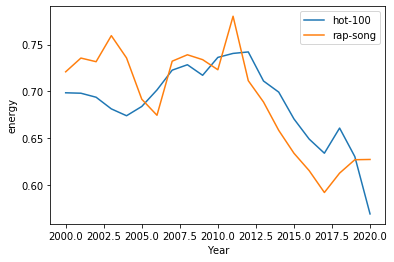

In [94]:
plot_year_trends('energy', time_track)

Energy pretty consistent throughout the years

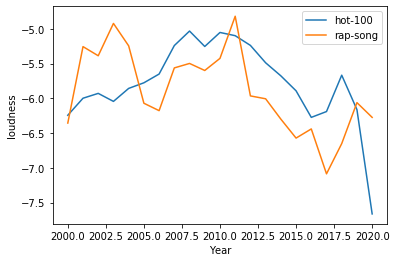

In [96]:
plot_year_trends('loudness', time_track)

Rap songs much louder in the early 2000's, then consistently quieter later on

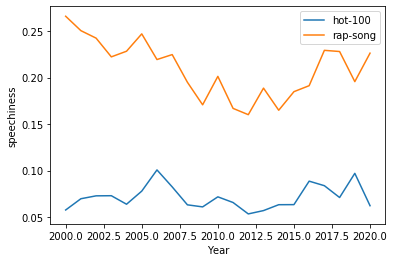

In [97]:
plot_year_trends('speechiness', time_track)

To no surprise, rap songs have more spoken words

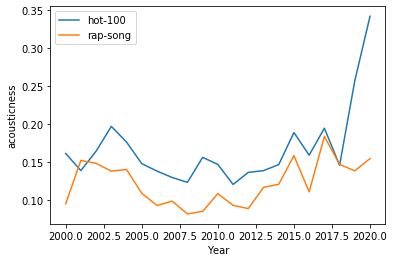

In [98]:
plot_year_trends('acousticness', time_track)

Rap songs have mostly been less acoustic than other songs

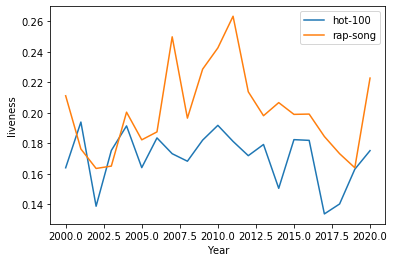

In [99]:
plot_year_trends('liveness', time_track)

Rap songs sounds like they're performed live more than other types of music

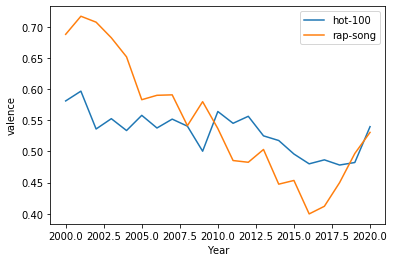

In [100]:
plot_year_trends('valence', time_track)

There has been a decrease in valence for rap music over the years

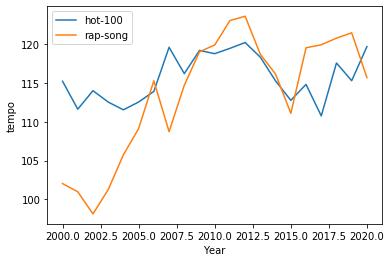

In [101]:
plot_year_trends('tempo', time_track)

Rap music has sped up a bit over the years

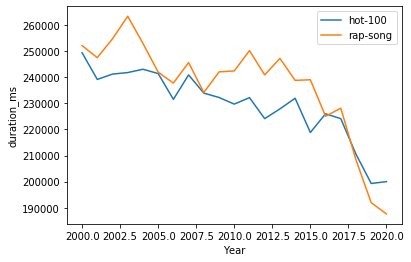

In [103]:
plot_year_trends('duration_ms', time_track)

Songs in general are getting shorter

### Feature engineering

In [158]:
years = [[i + 2000 for i in range(j,j+3)] for j in range(0, 20, 3)]

years_vals = ['00-02', '03-05', '06-08', '09-11', '12-14', '15-17', '18-20']

years_dict = {}

for b in range(0,7): 
    for i in years[b]:
        years_dict.update({i:years_vals[b]})

spotify_df['year_bucket'] = spotify_df['year'].map(years_dict)

le = LabelEncoder() 

spotify_df['year_bucket_le'] = le.fit_transform(spotify_df.year_bucket)

model_df = pd.get_dummies(spotify_df, columns=["year_bucket", "chart", "key_name", 'mode_name'], prefix=["year", "chart", "key", "mode"] )

labels = np.array(model_df['chart_rap-song'])

In [159]:
model_df.columns

Index(['artist', 'track', 'date', 'spotify_query', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri',
       'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'year',
       'key_full', 'year_bucket_le', 'year_00-02', 'year_03-05', 'year_06-08',
       'year_09-11', 'year_12-14', 'year_15-17', 'year_18-20', 'chart_hot-100',
       'chart_rap-song', 'key_A', 'key_Ab', 'key_B', 'key_Bb', 'key_C',
       'key_D', 'key_Db', 'key_E', 'key_Eb', 'key_F', 'key_G', 'key_Gb',
       'mode_major', 'mode_minor'],
      dtype='object')

In [160]:
spotify_df.head()

,artist,track,date,chart,spotify_query,danceability,energy,key,loudness,mode,...,track_href,analysis_url,duration_ms,time_signature,year,key_name,mode_name,key_full,year_bucket,year_bucket_le
0,NLE Choppa Featuring Roddy Ricch,Walk Em Down,2020-05-01,rap-song,NLE+Choppa+Walk+Em+Down,0.867,0.744,9,-5.171,0,...,https://api.spotify.com/v1/tracks/4cSSL3YafYjM...,https://api.spotify.com/v1/audio-analysis/4cSS...,173288,4,2020,A,minor,Aminor,18-20,6
1,DaBaby,Find My Way,2020-05-01,rap-song,DaBaby+Find+My+Way,0.836,0.624,4,-6.750,0,...,https://api.spotify.com/v1/tracks/1gVCEnryJhkd...,https://api.spotify.com/v1/audio-analysis/1gVC...,139890,4,2020,E,minor,Eminor,18-20,6
2,Drake,Toosie Slide,2020-05-01,rap-song,Drake+Toosie+Slide,0.834,0.454,1,-9.750,0,...,https://api.spotify.com/v1/tracks/127QTOFJsJQp...,https://api.spotify.com/v1/audio-analysis/127Q...,247059,4,2020,Db,minor,Dbminor,18-20,6
3,Roddy Ricch,The Box,2020-05-01,rap-song,Roddy+Ricch+The+Box,0.896,0.586,10,-6.687,0,...,https://api.spotify.com/v1/tracks/0nbXyq5TXYPC...,https://api.spotify.com/v1/audio-analysis/0nbX...,196653,4,2020,Bb,minor,Bbminor,18-20,6
4,DaBaby Featuring Roddy Ricch,Rockstar,2020-05-01,rap-song,DaBaby+Rockstar,0.746,0.690,11,-7.956,1,...,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,2020,B,major,Bmajor,18-20,6


In [161]:
# feature_names = ['danceability', 'energy','loudness','speechiness', 'acousticness',
#                 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms','year',
#                 'year_00-02', 'year_03-05', 'year_06-08','year_09-11', 'year_12-14', 'year_15-17', 'year_18-20',
#                 'key_A', 'key_Ab', 'key_B', 'key_Bb', 'key_C', 'key_D', 'key_Db', 'key_E', 
#                 'key_Eb', 'key_F', 'key_G', 'key_Gb',
#                 'mode_major']

# feature_names = ['danceability', 'energy','loudness', 'acousticness',
#                 'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',
#                 'key_A', 'key_Ab', 'key_B', 'key_Bb', 'key_C', 'key_D', 'key_Db', 'key_E', 
#                 'key_Eb', 'key_F', 'key_G', 'key_Gb',
#                 'mode_major']

feature_names = ['danceability', 'energy','loudness', 'acousticness', 'speechiness',
                'instrumentalness', 'liveness', 'valence', 'tempo','duration_ms',
                'key_A', 'key_Ab', 'key_B', 'key_Bb', 'key_C', 'key_D', 'key_Db', 'key_E', 
                'key_Eb', 'key_F', 'key_G', 'key_Gb',
                'mode_major']

In [162]:
model_df = model_df.loc[:, feature_names]

In [196]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(model_df, labels, 
                                                                            test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2637, 23)
Training Labels Shape: (2637,)
Testing Features Shape: (880, 23)
Testing Labels Shape: (880,)


In [197]:
test_features

,danceability,energy,loudness,acousticness,speechiness,instrumentalness,liveness,valence,tempo,duration_ms,...,key_Bb,key_C,key_D,key_Db,key_E,key_Eb,key_F,key_G,key_Gb,mode_major
2457,0.657,0.695,-4.493,0.010800,0.0321,0.000000,0.0822,0.683,131.9940,212107,...,0,0,1,0,0,0,0,0,0,1
70,0.850,0.516,-7.664,0.763000,0.0714,0.000000,0.0896,0.874,108.9630,158532,...,0,1,0,0,0,0,0,0,0,0
358,0.647,0.673,-5.992,0.172000,0.1760,0.000000,0.2230,0.527,89.9855,224000,...,0,0,0,0,0,0,1,0,0,1
325,0.635,0.847,-3.152,0.533000,0.4470,0.000000,0.1540,0.568,83.0360,234650,...,0,0,0,0,0,0,0,1,0,1
2208,0.719,0.847,-6.340,0.002010,0.0916,0.020400,0.2210,0.444,127.9630,242680,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2297,0.366,0.651,-3.842,0.000415,0.0310,0.005260,0.2710,0.257,151.3430,200707,...,0,0,0,0,1,0,0,0,0,1
1114,0.641,0.615,-7.475,0.036700,0.3890,0.000000,0.1050,0.411,137.8760,240147,...,0,0,0,1,0,0,0,0,0,1
3283,0.487,0.702,-6.043,0.005360,0.0238,0.000005,0.1290,0.306,95.9730,265907,...,0,0,0,0,0,0,0,1,0,1
3082,0.484,0.827,-5.324,0.003900,0.0460,0.001430,0.0876,0.717,89.7830,230760,...,0,0,0,0,0,0,0,0,0,1


In [198]:
RSEED = 50

In [199]:
model = RandomForestClassifier(n_estimators=100, 
            random_state=RSEED, 
            max_features = 'sqrt',
            n_jobs=-1, verbose = 1)

In [200]:
model.fit(train_features, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [201]:
train_rf_predictions = model.predict(train_features)
train_rf_probs = model.predict_proba(train_features)[:, 1]

rf_predictions = model.predict(test_features)
rf_probs = model.predict_proba(test_features)[:, 1]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [114]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, 
                                     [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, 
                                      [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();

Recall Baseline: 1.0 Test: 0.74 Train: 1.0
Precision Baseline: 0.48 Test: 0.85 Train: 1.0
Roc Baseline: 0.5 Test: 0.91 Train: 1.0


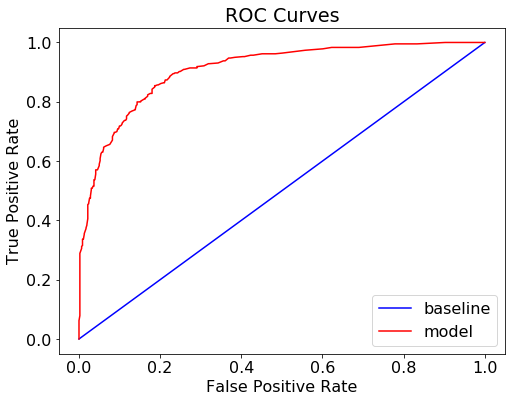

In [115]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

In [206]:
results = {}
    
results['recall'] = round(recall_score(test_labels, rf_predictions),2).tolist()
results['precision'] = round(precision_score(test_labels, rf_predictions),2)
results['roc'] = round(roc_auc_score(test_labels, rf_probs),2)

In [209]:
type(round(roc_auc_score(test_labels, rf_probs),2).tolist())

float

In [207]:
results

{'recall': 0.74, 'precision': 0.85, 'roc': 0.91}

In [116]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [117]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(model_df, labels,)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [118]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [119]:
best_random = rf_random.best_estimator_

In [133]:
type(best_random)

sklearn.ensemble._forest.RandomForestClassifier

In [167]:
gini_importance = best_random.feature_importances_.tolist()

In [168]:
features = model_df.columns.tolist()

In [169]:
feature_importance = pd.DataFrame({'features': features, 'gini_importance': gini_importance})

In [171]:
feature_importance.sort_values(by = 'gini_importance', ascending = False)

,features,gini_importance
4,speechiness,0.448757
0,danceability,0.156743
8,tempo,0.053975
9,duration_ms,0.052017
5,instrumentalness,0.047733
7,valence,0.045136
6,liveness,0.042711
3,acousticness,0.041679
1,energy,0.039132
2,loudness,0.036893


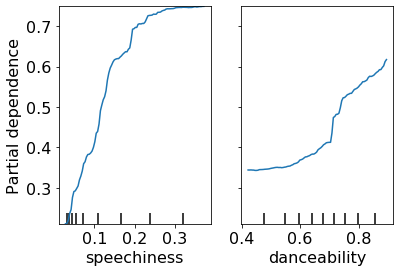

In [176]:
plot_partial_dependence(best_random, model_df, ['speechiness', 'danceability']) 

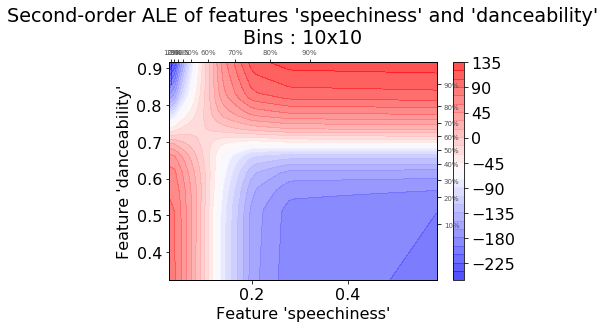

In [190]:
ale_plot(best_random, model_df, ['speechiness','danceability'], monte_carlo=True)

In [184]:
so_ale

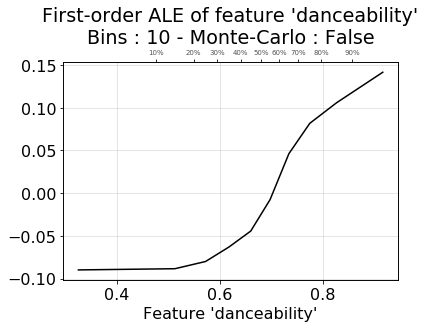

In [180]:
ale_plot(best_random, model_df, ['danceability'])

In [120]:
train_rf_predictions_rand = best_random.predict(train_features)
train_rf_probs_rand = best_random.predict_proba(train_features)[:, 1]

rf_predictions_rand = best_random.predict(test_features)
rf_probs_rand = best_random.predict_proba(test_features)[:, 1]

Recall Baseline: 1.0 Test: 0.88 Train: 0.88
Precision Baseline: 0.48 Test: 0.91 Train: 0.87
Roc Baseline: 0.5 Test: 0.98 Train: 0.97


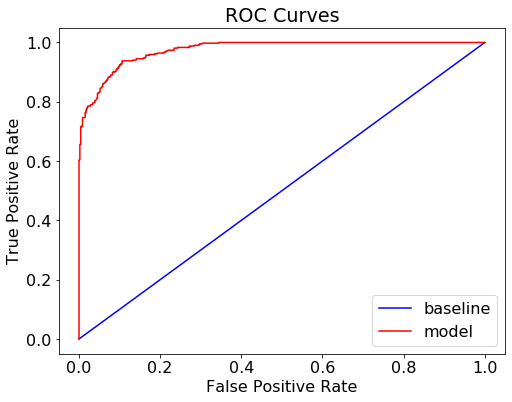

In [121]:
evaluate_model(rf_predictions_rand, rf_probs_rand, train_rf_predictions_rand, train_rf_probs_rand)

In [122]:
best_params = rf_random.best_params_

In [135]:
best_params

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [124]:
best_rf = RandomForestClassifier(**best_params)

In [125]:
best_rf.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [126]:
train_rf_predictions_best = best_rf.predict(train_features)
train_rf_probs_best = best_rf.predict_proba(train_features)[:, 1]

rf_predictions_best = best_rf.predict(test_features)
rf_probs_best = best_rf.predict_proba(test_features)[:, 1]

Recall Baseline: 1.0 Test: 0.78 Train: 0.88
Precision Baseline: 0.48 Test: 0.85 Train: 0.89
Roc Baseline: 0.5 Test: 0.91 Train: 0.98


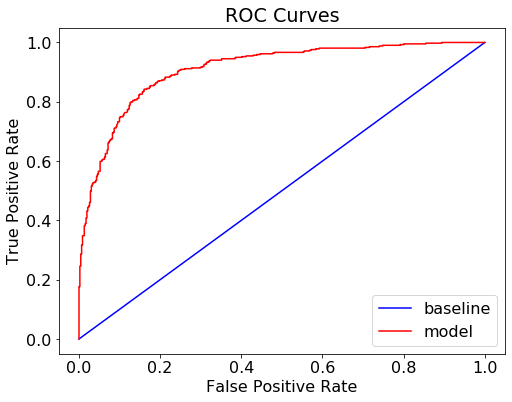

In [127]:
evaluate_model(rf_predictions_best, rf_probs_best, train_rf_predictions_best, train_rf_probs_best)